In [155]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import colors
import cartopy.crs as ccrs
import datetime as dt
import glob, os, sys
from matplotlib import animation
import matplotlib.path as mpath
import cartopy.feature as cfeature
import re
import os
import pandas as pd
import seaborn as sns
import math
import netCDF4 as nc

np.set_printoptions(threshold=np.inf)

In [156]:
#read new data file
ref_df = pd.read_csv('time_ref_full.csv')

#convert time format
ref_df['time'] = pd.to_datetime(ref_df['time'], format="%Y-%m-%d %H:%M:%S")

In [157]:
#first z-r relationship equation
z=10**(ref_df['ref']/10)
rcb=pow(z, 1/1.3)/25*1000

In [158]:
#second z-r relationship equation
z_2=10**(ref_df['ref']/10)
rcb_2=pow(z_2, 1/1.04)/6*1000

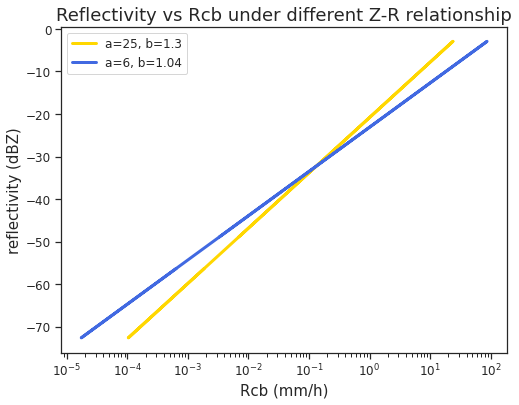

In [159]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)

# Plot data
ax1.plot(rcb,ref_df['ref'],label='a=25, b=1.3',linewidth=3,color='#FFD700')
ax1.plot(rcb_2,ref_df['ref'],label='a=6, b=1.04',linewidth=3,color='#4169E1')
plt.xscale('log')

# set x and y axis labels
ax1.set_xlabel('Rcb (mm/h)',fontsize=15)
ax1.set_ylabel('reflectivity (dBZ)',fontsize=15)

# add a plot title
ax1.set_title('Reflectivity vs Rcb under different Z-R relationship',fontsize=18)
# add legend
ax1.legend(fontsize=12)

# set ticks size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#save the plot
plt.savefig('/home/users/ee21y2d/plot/z-r.png',format ='png', dpi=150)

In [136]:
ref_df_2=ref_df

##for first z-r relationship
# add calculated rcb into dataframe
ref_df['rcb']=rcb

# extract minite imformation from time variables
ref_df['minute'] = ref_df['time'].apply(lambda x: str(x.year)+ '-'+ str(x.month)+ '-'+str(x.day)+ '_' +str(x.hour)+':'+str(x.minute))

#delete bad data
ref_df = ref_df.drop(ref_df[(ref_df['rcb']== 10)].index,axis = 0)

# Convert the rcb in every 5s measuremnts into an average per minute
ref_df["rcb_mean"] = ref_df.groupby('minute')["rcb"].transform('mean')

del ref_df['rcb']
del ref_df['time']
del ref_df['ref']

# Drop duplicates of minute average except for the first occurrence
ref_df = ref_df.drop_duplicates('minute',keep='first')

print(ref_df.head(5))
print(ref_df.tail(5))

              minute  rcb_mean
0    2016-10-20_19:8  0.000007
1    2016-10-20_19:9  0.000007
13  2016-10-20_19:10  0.000009
25  2016-10-20_19:11  0.000014
32  2016-10-20_19:13  0.000008
                 minute  rcb_mean
850733  2017-2-24_23:30  0.000006
850735  2017-2-24_23:35  0.000007
850745  2017-2-24_23:36  0.000007
850757  2017-2-24_23:37  0.000005
850758  2017-2-24_23:42  0.000003


In [137]:
##for second z-r relationship
# add calculated rcb into dataframe
ref_df_2['rcb']=rcb_2

# extract minite imformation from time variables
ref_df_2['minute'] = ref_df_2['time'].apply(lambda x: str(x.year)+ '-'+ str(x.month)+ '-'+str(x.day)+ '_' +str(x.hour)+':'+str(x.minute))

#delete bad data
ref_df_2 = ref_df_2.drop(ref_df_2[(ref_df_2['rcb']== 10)].index,axis = 0)

# Convert the rcb in every 5s measuremnts into an average per minute
ref_df_2["rcb_mean"] = ref_df_2.groupby('minute')["rcb"].transform('mean')

del ref_df_2['rcb']
del ref_df_2['time']
del ref_df_2['ref']

# Drop duplicates of minute average except for the first occurrence
ref_df_2 = ref_df_2.drop_duplicates('minute',keep='first')

print(ref_df_2.head(5))
print(ref_df_2.tail(5))

              minute  rcb_mean
0    2016-10-20_19:8  0.000003
1    2016-10-20_19:9  0.000004
13  2016-10-20_19:10  0.000005
25  2016-10-20_19:11  0.000008
32  2016-10-20_19:13  0.000004
                 minute  rcb_mean
850733  2017-2-24_23:30  0.000003
850735  2017-2-24_23:35  0.000004
850745  2017-2-24_23:36  0.000003
850757  2017-2-24_23:37  0.000002
850758  2017-2-24_23:42  0.000001


In [138]:
base_path = '/gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/'# the path contains all instrument measurement 

# set empty list and dictionary
filelist = []
filedic = {}
numdic={}

#define time period
begin = 20161020
end = 20170224

#Reads the list of files and folders in the specified path
second_path = os.listdir(base_path)
for second in second_path:
    if '.' not in second:
        filedir = os.path.join(base_path,second)
        files = os.listdir(filedir)
        
        # use regular expressions to find number string indicate the measurment date
        for file in files:
            find_number = re.compile("\d{8}") 
            number = re.findall(find_number,file)
            
            # compare number string with target time period 
            if number:
                number = number[0]                
                if begin<=int(number)<=end and not filedic.get(file, False) and not numdic.get(number, False) :
                    filelist.append(os.path.join(filedir,file))

In [139]:
# set empty list
nd_list = []
# use loop to append the file of target VAP
for i in filelist:
    if 'asindropmfrsrM1'in i:
        nd_list.append(i)
        
nd_list.sort()# sort in date order
print('nd size is',len(nd_list))
print(nd_list[0],nd_list[-1]) #print first and last datafile to check the measurment time

nd size is 128
/gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/229920/asindropmfrsrM1.c1.20161020.000000.custom.nc /gws/nopw/j04/asci/yixin/ftp.archive.arm.gov/dingy1/229920/asindropmfrsrM1.c1.20170224.000000.custom.nc


In [140]:
# make empty arrays
nd_array_lwp, nd_time, nd_array_cdnc,nd_array_lwp_qc, nd_array_cdnc_qc = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

#read .nc files
for f in nd_list:
    
    data_nd = Dataset(f,'r')
    #extract variables
    nd_data_time,time_unit=data_nd.variables['time'][:],data_nd.variables['time'].units
    data_time=nc.num2date(nd_data_time,units=time_unit)# Convert the time format
    data_cdnc = data_nd.variables['drop_number_conc'][:]
    data_cdnc_qc = data_nd.variables['qc_drop_number_conc'][:]
    data_lwp = data_nd.variables['lwp_meas'][:]
    data_lwp_qc = data_nd.variables['qc_lwp_meas'][:]
    
    #append numpy array
    nd_array_lwp = np.append(nd_array_lwp,data_lwp)
    nd_array_lwp_qc = np.append(nd_array_lwp_qc,data_lwp_qc)
    nd_time = np.append(nd_time,data_time)
    nd_array_cdnc = np.append(nd_array_cdnc,data_cdnc)
    nd_array_cdnc_qc = np.append(nd_array_cdnc_qc,data_cdnc_qc)


In [141]:
#unit conversion from m-3 to cm-3
cdnc=nd_array_cdnc/1000000

#unit conversion from kg m-2 to g m-2
lwp=nd_array_lwp*1000

In [142]:
#stack time,lwp, cdnc and quality check of lwp and cdnc arrays along axis 1
nd_array=np.stack((nd_time, cdnc, nd_array_cdnc_qc, lwp, nd_array_lwp_qc), axis=1) 

# Convert NumPy Array to Pandas DataFrame
nd_df = pd.DataFrame(nd_array)

# define the columns name
nd_df.columns = ['time','cdnc','cdnc_qc', 'lwp', 'lwp_qc']

# extract minite imformation from time variables
nd_df['minute'] = nd_df['time'].apply(lambda x: str(x.year)+ '-'+ str(x.month)+ '-'+str(x.day)+ '_' +str(x.hour)+':'+str(x.minute))

# filter incorrect data by using 'qc' quality check
nd_df_clear = nd_df.drop(nd_df[(nd_df['lwp']== -9999.0)|(nd_df['cdnc']== -9999.0)|(nd_df['lwp_qc']!=0)|(nd_df['cdnc_qc']!=0)|(nd_df['lwp']==0)].index,axis = 0)

del nd_df_clear['cdnc_qc']
del nd_df_clear['lwp_qc']
del nd_df_clear['time']

# Convert the lwp and cdnc in every 20s measuremnts into an average per minute
nd_df_clear["lwp_mean"] = nd_df_clear.groupby('minute')["lwp"].transform('mean')
nd_df_clear["cdnc_mean"] = nd_df_clear.groupby('minute')["cdnc"].transform('mean')

del nd_df_clear['cdnc']
del nd_df_clear['lwp']

# Drop duplicates of minute average except for the first occurrence
nd_df_clear = nd_df_clear.drop_duplicates('minute',keep='first')

print(nd_df_clear.head(5))
print(nd_df_clear.tail(5))

               minute    lwp_mean   cdnc_mean
1330  2016-10-20_7:23  153.652824   78.528962
1333  2016-10-20_7:24  141.093843  140.356190
1335  2016-10-20_7:25  144.631892   74.221691
1339  2016-10-20_7:26  106.737617  102.214792
1341  2016-10-20_7:27  126.856238   91.974697
                 minute    lwp_mean   cdnc_mean
551934  2017-2-24_18:24  108.495742   38.420011
551937  2017-2-24_18:25   87.669621  103.677459
551940  2017-2-24_18:26  107.318622  138.128063
551943  2017-2-24_18:27  125.407686   70.586176
551946  2017-2-24_18:28  149.441410   45.683459


In [143]:
#join two datafram use intersection of keys from both frames
df = pd.merge(ref_df, nd_df_clear, how='inner')


# define the columns name
df.columns = ['minute','rcb','lwp','cdnc']
df['ratio']=df['lwp']/df['cdnc']
print(df[90:100])
print(df.tail(5))

# creat cdnc range condition(Just to look at the rough distribution) 
conditions = [
    (df['cdnc'] >0) & (df['cdnc'] <= 100),
    (df['cdnc'] > 100) & (df['cdnc'] <= 200), 
    (df['cdnc'] > 200) & (df['cdnc'] <= 300),
    (df['cdnc'] > 300) & (df['cdnc'] <= 400),
    (df['cdnc'] > 400) & (df['cdnc'] <= 500),
    (df['cdnc'] > 500) 
     ]

# create a list of the values we want to assign for each condition
values = [0,1,2,3,4,5]

# create a new column and use np.select to assign values to it using our lists as arguments
df['CDNC range'] = np.select(conditions, values)

# display updated DataFrame
df.head(5)

# check the CDNC distribution
counts = df.groupby('CDNC range')['cdnc'].count()
print(counts)

              minute           rcb         lwp        cdnc     ratio
90  2016-10-21_11:28  7.501760e-07   64.874662  238.013088  0.272568
91  2016-10-21_11:30  1.424645e-06   58.769541  536.755184  0.109490
92  2016-10-21_11:31  1.301734e-06  105.319957  204.877035  0.514064
93  2016-10-21_11:32  1.227537e-06  101.534441  183.579117  0.553083
94  2016-10-21_11:33  1.074902e-06   74.416928  411.403296  0.180886
95  2016-10-21_11:34  2.528771e-06  133.724911  194.006171  0.689282
96  2016-10-21_11:35  2.127609e-06  124.182314  306.097461  0.405695
97  2016-10-21_11:36  4.810493e-06  355.923603   98.371835  3.618145
98  2016-10-21_11:37  5.152753e-06  486.253848   63.167912  7.697798
99  2016-10-21_11:38  4.475081e-06  116.717075  257.240080  0.453728
                minute       rcb         lwp        cdnc     ratio
33051  2017-2-24_18:24  0.000002  108.495742   38.420011  2.823938
33052  2017-2-24_18:25  0.000002   87.669621  103.677459  0.845600
33053  2017-2-24_18:26  0.000002  107.31

In [160]:
# creat new cdnc range condition 
conditions = [
    (df['cdnc'] >0) & (df['cdnc'] <= 20),
    (df['cdnc'] > 20) & (df['cdnc'] <= 70),#
    (df['cdnc'] > 70) & (df['cdnc'] <= 120),
    (df['cdnc'] > 120) & (df['cdnc'] <= 170),#
    (df['cdnc'] > 170) & (df['cdnc'] <= 220),
    (df['cdnc'] > 220) & (df['cdnc'] <= 270),#
    (df['cdnc'] >270 ) ]

# create a list of the values we want to assign for each condition
values = ['nan','20-70 cm$^{-3}$','nan','120-170 cm$^{-3}$','nan','220-270 cm$^{-3}$','nan']

# create a new column and use np.select to assign values to it using our lists as arguments
df['CDNC range'] = np.select(conditions, values)

# display updated DataFrame
df = df.drop(df[(df['CDNC range']=='nan')].index,axis = 0)
df.head(5)

,minute,rcb,lwp,cdnc,ratio,CDNC range
1,2016-10-21_7:28,0.001155,152.886391,22.715747,6.730414,20-70 cm$^{-3}$
2,2016-10-21_7:31,0.001364,65.279797,239.338720,0.272751,220-270 cm$^{-3}$
3,2016-10-21_7:32,0.002519,150.171846,44.087820,3.406198,20-70 cm$^{-3}$
4,2016-10-21_7:33,0.001800,150.171846,37.865448,3.965933,20-70 cm$^{-3}$
5,2016-10-21_7:34,0.001606,164.257273,35.474369,4.630309,20-70 cm$^{-3}$


In [161]:
#join two datafram use intersection of keys from both frames
df_2 = pd.merge(ref_df_2, nd_df_clear, how='inner')

# define the columns name
df_2.columns = ['minute','rcb','lwp','cdnc']
df_2['ratio']=df_2['lwp']/df_2['cdnc']
print(df_2[90:100])
print(df_2.tail(5))

# creat new cdnc range condition 
conditions = [
    (df_2['cdnc'] >0) & (df_2['cdnc'] <= 20),
    (df_2['cdnc'] > 20) & (df_2['cdnc'] <= 70),#
    (df_2['cdnc'] > 70) & (df_2['cdnc'] <= 120),
    (df_2['cdnc'] > 120) & (df_2['cdnc'] <= 170),#
    (df_2['cdnc'] > 170) & (df_2['cdnc'] <= 220),
    (df_2['cdnc'] > 220) & (df_2['cdnc'] <= 270),#
    (df_2['cdnc'] >270 ) ]
# create a list of the values we want to assign for each condition
values = ['nan','20-70 cm$^{-3}$','nan','120-170 cm$^{-3}$','nan','220-270 cm$^{-3}$','nan']

# create a new column and use np.select to assign values to it using our lists as arguments
df_2['CDNC range'] = np.select(conditions, values)

# display updated DataFrame

df_2 = df_2.drop(df_2[(df_2['CDNC range']=='nan')].index,axis = 0)
df_2.head(5)

              minute           rcb         lwp        cdnc     ratio
90  2016-10-21_11:28  2.209869e-07   64.874662  238.013088  0.272568
91  2016-10-21_11:30  4.663597e-07   58.769541  536.755184  0.109490
92  2016-10-21_11:31  4.297431e-07  105.319957  204.877035  0.514064
93  2016-10-21_11:32  3.877076e-07  101.534441  183.579117  0.553083
94  2016-10-21_11:33  3.459392e-07   74.416928  411.403296  0.180886
95  2016-10-21_11:34  9.852138e-07  133.724911  194.006171  0.689282
96  2016-10-21_11:35  8.614434e-07  124.182314  306.097461  0.405695
97  2016-10-21_11:36  2.220937e-06  355.923603   98.371835  3.618145
98  2016-10-21_11:37  2.327695e-06  486.253848   63.167912  7.697798
99  2016-10-21_11:38  2.055787e-06  116.717075  257.240080  0.453728
                minute           rcb         lwp        cdnc     ratio
33051  2017-2-24_18:24  6.947063e-07  108.495742   38.420011  2.823938
33052  2017-2-24_18:25  7.968134e-07   87.669621  103.677459  0.845600
33053  2017-2-24_18:26  6.57

,minute,rcb,lwp,cdnc,ratio,CDNC range
1,2016-10-21_7:28,3.744924e-07,152.886391,22.715747,6.730414,20-70 cm$^{-3}$
2,2016-10-21_7:31,4.552861e-07,65.279797,239.338720,0.272751,220-270 cm$^{-3}$
3,2016-10-21_7:32,9.352083e-07,150.171846,44.087820,3.406198,20-70 cm$^{-3}$
4,2016-10-21_7:33,6.141223e-07,150.171846,37.865448,3.965933,20-70 cm$^{-3}$
5,2016-10-21_7:34,5.583788e-07,164.257273,35.474369,4.630309,20-70 cm$^{-3}$


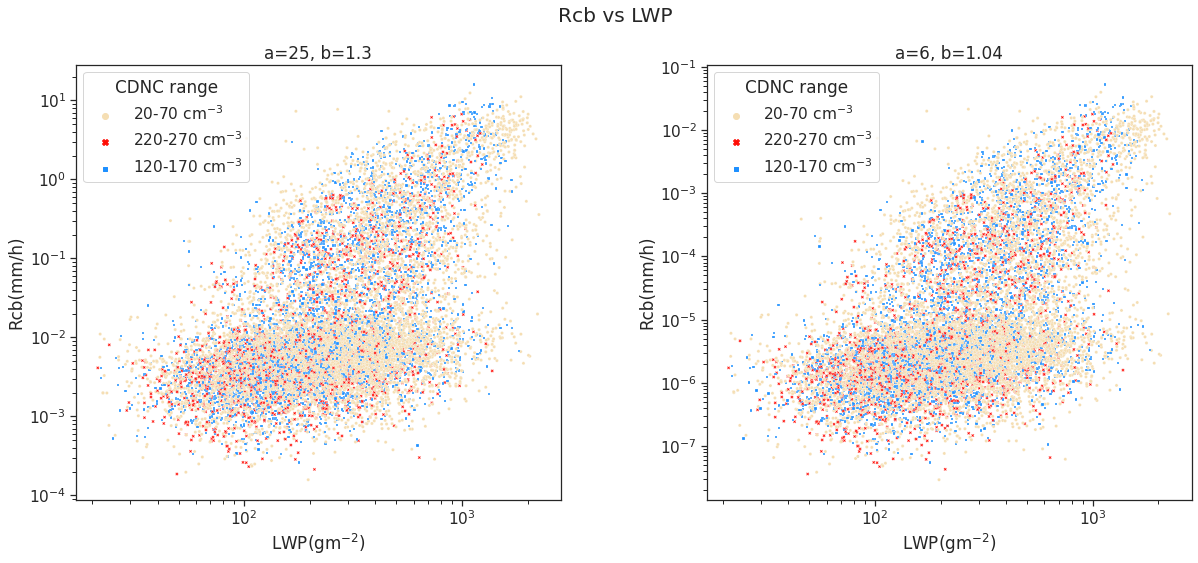

In [164]:
# Plot each z-r relationship condition in a separate subplot
f, ax = plt.subplots(1, 2, figsize=(20, 8))
#set distance between subplot
f.subplots_adjust(wspace=0.3)
#set plot theme
sns.set_theme(style="ticks",font_scale=1.4)
f.suptitle("Rcb vs LWP")

#set color scheme
colors = ['#F5DEB3',"#FF0B04","#1E90FF"]
customPalette = sns.set_palette(sns.color_palette(colors))

#scatterplot under two Z-R condition
sns.scatterplot(ax=ax[0],data = df,x = 'lwp',  y = 'rcb', hue = 'CDNC range',s=10, style='CDNC range',palette=customPalette)
sns.scatterplot(ax=ax[1],data = df_2,x = 'lwp',  y = 'rcb', hue = 'CDNC range',s=10, style='CDNC range',palette=customPalette)

#set title and axis 
ax[0].set(xscale="log",yscale="log",xlabel="LWP(gm$^{-2}$)", ylabel="Rcb(mm/h)")
ax[1].set(xscale="log",yscale="log",xlabel="LWP(gm$^{-2}$)", ylabel="Rcb(mm/h)")
ax[0].set_title("a=25, b=1.3")
ax[1].set_title("a=6, b=1.04")

#save the plot
plt.savefig('/home/users/ee21y2d/plot/rcb_lwp.png',format ='png', dpi=150)



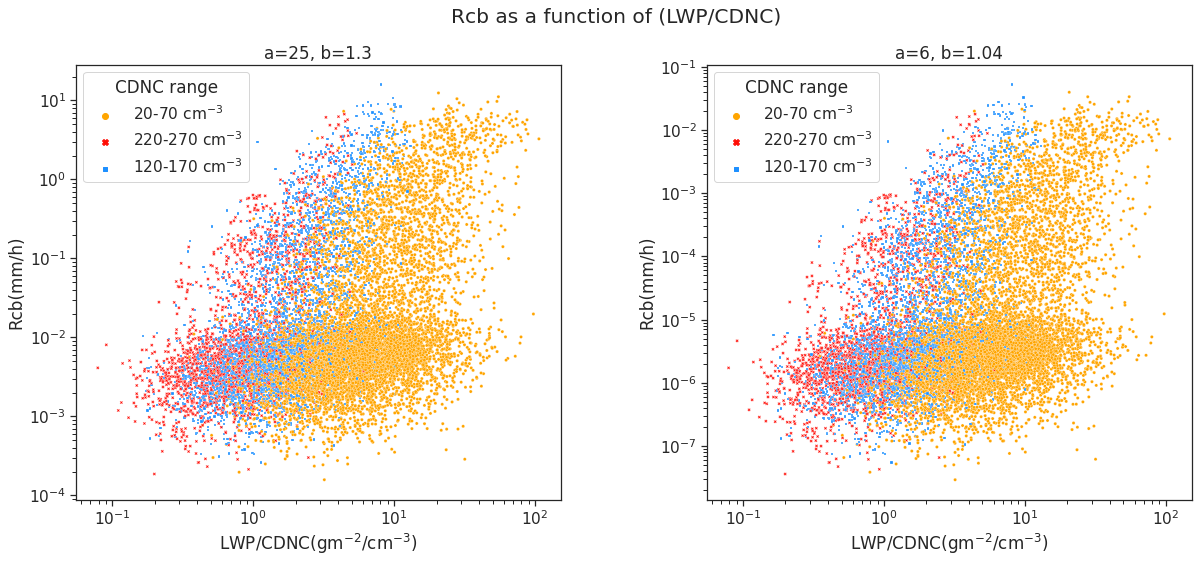

In [165]:
# Plot each z-r relationship condition in a separate subplot
f, ax = plt.subplots(1, 2, figsize=(20, 8))
#set distance between subplot
f.subplots_adjust(wspace=0.3)
#set plot theme
sns.set_theme(style="ticks",font_scale=1.4)
f.suptitle("Rcb as a function of (LWP/CDNC)")

#set color scheme
colors = ['Orange',"#FF0B04","#1E90FF"]
customPalette = sns.set_palette(sns.color_palette(colors))

#scatterplot under two Z-R condition
sns.scatterplot(ax=ax[0],data = df,x = 'ratio',  y = 'rcb', hue = 'CDNC range',s=10, style='CDNC range',palette=customPalette)
sns.scatterplot(ax=ax[1],data = df_2,x = 'ratio',  y = 'rcb', hue = 'CDNC range',s=10, style='CDNC range',palette=customPalette)

#set title and axis 
ax[0].set(xscale="log",yscale="log",xlabel="LWP/CDNC(gm$^{-2}$/cm$^{-3}$)", ylabel="Rcb(mm/h)")
ax[1].set(xscale="log",yscale="log",xlabel="LWP/CDNC(gm$^{-2}$/cm$^{-3}$)", ylabel="Rcb(mm/h)")
ax[0].set_title("a=25, b=1.3")
ax[1].set_title("a=6, b=1.04")

#save the plot
plt.savefig('/home/users/ee21y2d/plot/ratio.png',format ='png', dpi=150)



